# Tensor Pipeline

This note book runs the  lsr structured tensor ridge regression model with the following parameters fixed.

1. Ridge regression coefficient: 
2. Max iterations
3. Separation Rank
4. Tucker Rank



## Install Libraries

In [1]:
%pip install dill

Note: you may need to restart the kernel to use updated packages.


## System Path

In [2]:
import sys
import platform

# Check the operating system
if platform.system() == "Windows":
    # Using double backslashes
    sys.path.append(r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Closed_Form_Solver\Code Files")
elif platform.system() == "Darwin":  # macOS
    # Append path for macOS
     sys.path.append("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Code Files")
     sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP')

## Import Libraries

In [3]:
#Import sklearn stuff
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#Used to load data from pkl file
import dill

#Import External Files
from KFoldCV import KFoldCV
from train_test import train_test
from DataGenerationB import *

## Functions we  need

In [4]:
#conversion of the HCP data from Vector --> Matrix

def vectomat_matlab(vector, outputdim):
    '''
    This code is to regenerate the symmetric functional connectivity matrix from the given vectorized upper triangular portion.
    This code accounts for the mismatch between MATLAB and Python indexing.

    vector: ndarray - the sample vector as a column vector (:,1)
    outputdim: scalar - the dimension of the symmetric matrix
    '''

    # Checking whether the vector dimension and the desired output dimensions match
    vector_length = vector.shape[0]
    desired_length = outputdim * (outputdim - 1) / 2

    # Check if lengths match and raise an error if not
    if vector_length != desired_length:
        raise ValueError("Vector length is insufficient to construct the symmetric matrix.")
    
    # Create a symmetric matrix with zeros
    matrix = np.zeros((outputdim, outputdim))
    
    p = 0
    
    for i in range(outputdim):
        for j in range (i,outputdim):
            if i == j :
                matrix[i,j] = 1
            else:
                matrix[i,j] = vector[p]
                matrix[j,i] = matrix[i,j]
                p = p+1
                
    return matrix


def samplestomat(dataset,outputdim):
    
    '''
    This code is developed to convert the vectorized data matrix in to a 3D data tensor.
    
    dataset : nd:array - (samples*features)
    outputdim : scalar

    '''

    #number of samples
    n_samples = dataset.shape[0]
    #3D matrix to hold the output
    out_dataset = np.zeros((n_samples,outputdim,outputdim))

    for p in range(n_samples):
        
        sample = dataset[p]
        sample = vectomat_matlab(sample,outputdim)
        out_dataset[p] = sample

    random_index = np.random.randint(0, n_samples)
    random_sample = out_dataset[random_index]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(random_sample, cmap='viridis', cbar=True)
    plt.title(f'Heatmap of Random Sample {random_index}')
    plt.show()

    return out_dataset


def normalize_by_frobenius_norm(samples):
    """
    Normalizes each sample (2D matrix) in the array by its Frobenius norm.

    Parameters:
    samples (numpy.ndarray): A 3D numpy array with dimensions [samples, rows, columns].

    Returns:
    numpy.ndarray: A 3D numpy array with each sample normalized by its Frobenius norm.
    """
    # Calculate the Frobenius norm for each sample
    frobenius_norms = np.linalg.norm(samples, axis=(1, 2))
    
    # Reshape the norms to broadcast correctly for division
    frobenius_norms = frobenius_norms[:, np.newaxis, np.newaxis]
    
    # Normalize each sample by its Frobenius norm
    normalized_samples = samples / frobenius_norms
    
    return normalized_samples
        





## Import Data

In [5]:
import platform
import numpy as np

if platform.system() == "Windows": 
    file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\fmri_rs.npy"
elif platform.system() == "Darwin":
    file_path = r"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/fmri_rs.npy"  # Adjust the path for macOS

with open(file_path, "rb") as f:
    fmri_rs = np.load(f)

# Each sample is a row
fmri_rs = fmri_rs.T


# Determine the platform and load the appropriate file
if platform.system() == "Windows": 
    mat_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_60_splits.mat"
elif platform.system() == "Darwin":
    mat_file_path = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_60_splits.mat"
else:
    raise ValueError("Unsupported platform")

# Load the .mat file
mat_file = scipy.io.loadmat(mat_file_path)

#Iterating over seeds


1. Need Parameters

In [6]:
#number of seeds we are considering 
number_seeds = [1,9,10]

#hyper parameters
tensor_dimensions = np.array([400,400])
tensor_mode_ranks = np.array([4,4])
separation_rank = 2

#For now, define finite alpha set that we are searching over
alphas =  [0.1,0.4,0.7,1,1.5,2,2.5,3,3.5,4,5,10,15,20,25,30]

# The dataframe to hold the results for a seed
columns = ['Seed', 'Best Lambda', 'NMSE', 'CORR', 'R2', 'Time Taken', 'Gradient']
results_df = pd.DataFrame(columns=columns)



=======================================================SEED : {seed} ========================================================================


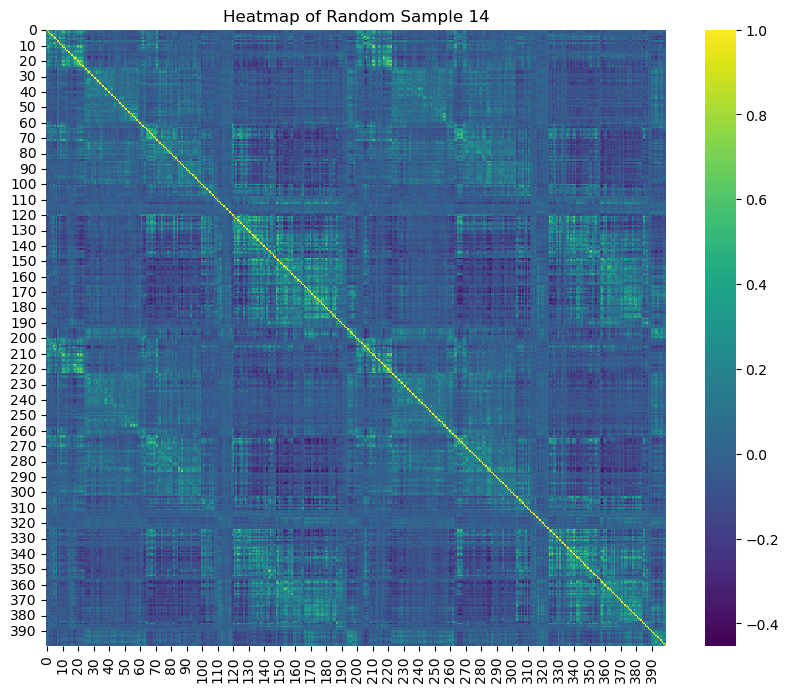

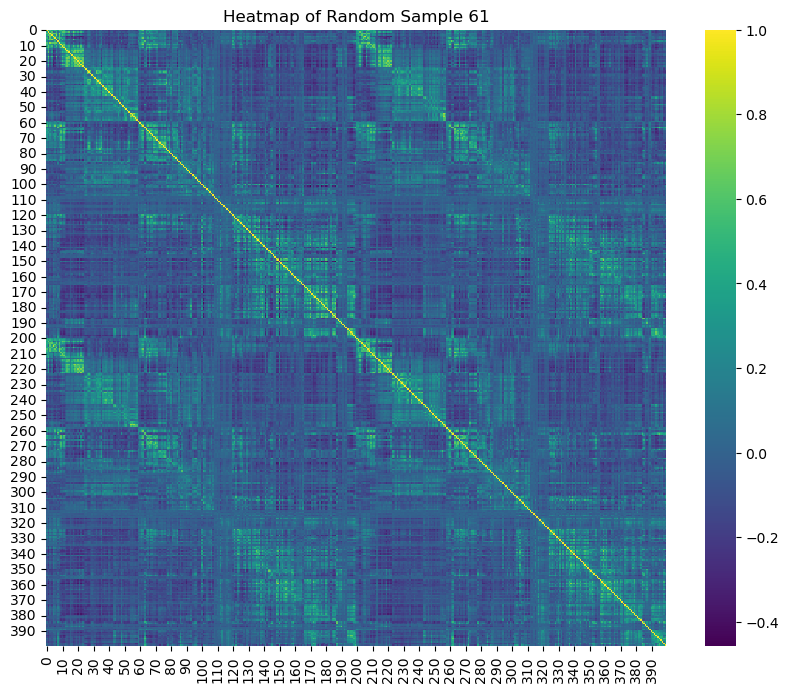

(677, 400, 400)
(677,)
(76, 400, 400)
(76,)
Sample mean for each feature (across samples): [0.01744328 0.00567473 0.00616794 ... 0.00342109 0.00506012 0.01744328]
Sample variance for each feature (across samples): None
Response Average: 1.127096656182391
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not ini

c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\raman\anaconda3\envs\torchtensor\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold = 1, Alpha = 0.1, NMSE: 1.3019036527168246, Correlation: 0.44631989375015635, R^2 Score: -0.3022531064916052
Fold = 1, Alpha = 0.4, NMSE: 1.3180239546222081, Correlation: 0.4211540814730086, R^2 Score: -0.3183777353687578
Fold = 1, Alpha = 0.7, NMSE: 1.2441560802561424, Correlation: 0.4590312518542454, R^2 Score: -0.24449003356962629
Fold = 1, Alpha = 1, NMSE: 1.1313610215787993, Correlation: 0.4825386811469201, R^2 Score: -0.13166469872019526


In [7]:

for  number,seed in enumerate(number_seeds):
    
    print('')
    print('=======================================================SEED : {seed} ========================================================================')
        
    # Extract subject lists from the loaded file
    seed_1 = mat_file['folds'][f'seed_{seed}'][0, 0]
    subject_lists = seed_1['sub_fold'][0, 0]['subject_list']
    test_subjects = [int(item[0]) for item in subject_lists[0, 0].flatten()]

    #Getting the HCP test subjects 

    #array to hold the  subjects
    HCP_753_Subjects = []

    #setting the file path
    if platform.system() == "Windows":
        file_path = r'D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_753_subs.txt'
    elif platform.system() == "Darwin":
        file_path = '/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_753_subs.txt'
    #if file pat  h is returned then load
    if file_path:
        try:
            with open(file_path, 'r') as file:
                HCP_753_Subjects = [int(line.strip()) for line in file.readlines()]
        except Exception as e:
            print(f"An error occurred: {e}")


    #Put the HCP test subjects into a dataframe
    # Determine the platform and load the appropriate file
    if platform.system() == "Windows":
        csv_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_componentscores.csv"
    elif platform.system() == "Darwin":
        csv_file_path = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_componentscores.csv"

    df = pd.read_csv(csv_file_path)
    df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
    df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

    #Split all our data into a Train and Test Set
    df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

    #Create train and test arrays
    train_subjects = df_train.index.to_list()
    test_subjects = df_test.index.to_list()

    #Reshape labels into column vector
    X_train_vec, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
    X_test_vec, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

    #Training data
    X_train = samplestomat(X_train_vec,400)
    X_test  = samplestomat(X_test_vec,400)
    Y_train = Y_train.reshape(-1)
    Y_test = Y_test.reshape(-1)


    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)

    #Function to row wise normalizati

    X_train = normalize_by_frobenius_norm(X_train)
    X_test = normalize_by_frobenius_norm(X_test)

    #number of samples in train and test 
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    # Reshape the 3D array to a 2D array where each row represents a sample
    # The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
    # We reshape it to (n_samples, n_features_per_sample * n_dimensions)

    X_train_2D = X_train.reshape(n_train, -1)
    X_test_2D = X_test.reshape(n_test,-1)

    # Initialize StandardScaler
    scaler = StandardScaler(with_std = False) #standard scalar only

    # Fit scaler on train data and transform train data
    X_train_scaled = scaler.fit_transform(X_train_2D)
    # Transform test data using the scaler fitted on train data
    X_test_scaled = scaler.transform(X_test_2D)

    # Reshape the scaled data back to 3D
    X_train = X_train_scaled.reshape(n_train, X_train.shape[1],X_train.shape[2])
    X_test  = X_test_scaled.reshape(n_test, X_test.shape[1],X_train.shape[2])

    #average response value
    Y_train_mean = np.mean(Y_train)
    # Mean centering y_train and y_test
    Y_train = Y_train - Y_train_mean


    print("Sample mean for each feature (across samples):",scaler.mean_)
    print("Sample variance for each feature (across samples):",scaler.var_)
    print('Response Average:',Y_train_mean)

    #Training

    #Define Number of Folds we want
    k_folds = 5
    hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
    lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information,gradient_information = KFoldCV(X_train, Y_train, alphas, k_folds, hypers, B_tensored = None, intercept= False)

    #Tesing 

    start_time = time.time()
    hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
    test_normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_level_values,iterate_level_reconstructed_tensor = train_test(X_train, Y_train, X_test, Y_test, lambda1, hypers,Y_train_mean, B_tensored = None, intercept= False)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f'Time for one lambda:{execution_time}')

    #saving data of one seed

    formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    max_iter = hypers['max_iter']

    if platform.system() == "Windows":
        pkl_file = rf"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression_All_Data\Closed_Form_Solver\LSR\Separation Rank 2\Normalize_Int_Removal\Frobenious\679\Results\HCP_lambdas_{alphas}_seed_{seed}_sep_{separation_rank}_tucker_{tensor_mode_ranks}.pkl"
    elif platform.system() == "Darwin":
        pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Stochastic LSR TRR/Experimental Results/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

    #printing error matrices for one seed

    print(f'SEED: {seed+1} : lambda1:{lambda1} : TNMSE:{test_nmse_loss} : TCORR:{test_correlation} : TR2: {test_R2_loss} ')

    #saving the data for one seed
    with open(pkl_file, "wb") as file:
        dill.dump((X_train,Y_train,X_test,Y_test, lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information,gradient_information,test_normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values,iterate_level_values,factor_core_iteration), file)

    #loading the results to the dataframe

    best_lambda = lambda1
    nmse = test_nmse_loss
    corr = test_correlation
    r2 = test_R2_loss
    time_taken = execution_time
    
    # Assuming gradient_values is your array
    if np.isnan(gradient_values).any():
        gradient = gradient_values
    else:
        gradient = gradient_values[-1,:,:]
    
    # Append the results to the dataframe
    seed_result_df = pd.DataFrame([{
        'Seed': seed,
        'Best Lambda': best_lambda,
        'NMSE': nmse,
        'CORR': corr,
        'R2': r2,
        'Time Taken': time_taken,
        'Gradient': gradient
    }])
    
    #concatenating the results
    results_df = pd.concat([results_df,seed_result_df], ignore_index = True) 

    # Define platform-specific file paths
    if platform.system() == 'Windows':
        file_path = r'D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression_All_Data\Closed_Form_Solver\LSR\Separation Rank 2\Normalize_Int_Removal\Frobenious\679\Results'
    elif platform.system() == 'Darwin':
        file_path = 'addpath'  # Replace 'addpath' with the actual path for macOS

    # Save the result as a CSV
    results_df.to_csv(f'{file_path}/results_with_matrix_{seed}.csv', index=False)
